## Tutorial: Laminar flow around a cylinder

We investigate the dipole sound arising from the periodic vortex shedding of a cylinder with radius $R=0.5$ for Mach number $\operatorname{Ma}_\infty=0.2$, Reynolds number $\operatorname{Re}_\infty=150$ and Prandtl number $\operatorname{Pr}_\infty=0.72$.
From DNS results, we know that the Strouhal number is $\operatorname{St} \sim 0.18$, the lift coefficient amplitude $c_l \sim 0.5$ and the temporal mean drag coefficient $c_d \sim 1.3$.

In [1]:
import ngsolve as ngs
from netgen import occ
from ngsolve.webgui import Draw

# Import necessary modules
from dream.compressible import CompressibleFlowSolver, Initial, FarField, Outflow, GRCBC, AdiabaticWall, flowfields
from dream.io import BoundarySensor, PointSensor
import numpy as np


ngs.ngsglobals.msg_level = 0
ngs.SetNumThreads(4)

In [2]:
# Create mesh
R = 0.5
RO = 50

# Mesh
dom = occ.WorkPlane().MoveTo(0, -RO).Arc(RO, 180, 'outflow').Arc(RO, 180, 'farfield').Circle(0, 0, R).Reverse().Face()
dom.edges[2].name = 'cylinder'
dom.edges[2].maxh = 0.15
mesh = ngs.Mesh(occ.OCCGeometry(dom, dim=2).GenerateMesh(maxh=20, grading=0.15))

# Omesh
# from dream.mesh import get_cylinder_omesh
# mesh = get_cylinder_omesh(R, RO, 40, 20, 2.5, ('cylinder', 'farfield', 'outflow'))

Draw(mesh)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

In [ ]:
# Set configuration
cfg = CompressibleFlowSolver(mesh)
cfg.time = 'transient'
cfg.time.timer.interval = (0, 200)
cfg.time.timer.step = 0.5 # Equivalent to a sampling Strouhal number of 5, Dipole shedding frequency St ~0.18

cfg.mach_number = 0.2
cfg.reynolds_number = 150
cfg.prandtl_number = 0.72
cfg.equation_of_state = 'ideal'
cfg.equation_of_state.heat_capacity_ratio = 1.4
cfg.riemann_solver = 'upwind'
cfg.dynamic_viscosity = 'constant'
cfg.scaling = 'aerodynamic'

cfg.fem = 'conservative'
cfg.fem.order = 2
cfg.fem.method = 'hdg'
cfg.fem.mixed_method = 'strain_heat'
cfg.fem.scheme = 'bdf2'

cfg.nonlinear_solver = 'pardiso'
cfg.nonlinear_solver.method = 'newton'
cfg.nonlinear_solver.method.damping_factor = 1
cfg.nonlinear_solver.max_iterations = 5
cfg.nonlinear_solver.convergence_criterion = 1e-8

cfg.optimizations.bonus_int_order.bnd = cfg.fem.order
cfg.optimizations.bonus_int_order.vol = cfg.fem.order
cfg.optimizations.static_condensation = True
cfg.optimizations.compile.realcompile = False

mesh.Curve(cfg.fem.order);

In [4]:
# Setup boundary and initial fields
Uinf = cfg.get_farfield_fields((1, 0))

U0 = flowfields()
U0.u = Uinf.u
U0.rho = Uinf.rho
U0.p = Uinf.p

# r2 = (ngs.x + 5)**2 + (ngs.y+1)**2
# U0.u = Uinf.u + ngs.CF((1e-2 * ngs.exp(-r2), 0))

cfg.dcs['default'] = Initial(fields=U0)

In [5]:
def flow_around_cylinder_routine(func):

    def wrapper(*args, **kwargs):

        # Set I/O options
        cfg.io.settings.enable = True
        cfg.io.settings.to_pickle = True
        cfg.io.settings.to_txt = True
        cfg.io.ngsmesh.enable = True
        cfg.io.gfu.enable = True
        cfg.io.gfu.rate = 1

        # Set logging paths
        cfg.io.log.to_terminal = True
        cfg.io.log.to_file = False
        cfg.io.path = func.__name__ + f'/M{cfg.mach_number.Get()}'
        cfg.io.log.to_file = True

        # Clear previous boundary conditions and set new ones
        cfg.bcs.clear()
        cfg.bcs['cylinder'] = AdiabaticWall()
        cfg.bcs['farfield'] = GRCBC(Uinf, relaxation_factor=0.01)
        func(*args, **kwargs)

        # Initialize and solve the configuration
        cfg.initialize()

        Uh = cfg.get_solution_fields()

        cfg.io.draw({"p'": Uh.p - Uinf.p,
                     "u'": Uh.u - Uinf.u})

        with ngs.TaskManager():
            cfg.solve()

    return wrapper

In [6]:
@flow_around_cylinder_routine
def farfield():
    cfg.bcs['outflow'] = FarField(Uinf)
farfield()

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

In [ ]:
@flow_around_cylinder_routine
def grcbc():
    cfg.bcs['outflow'] = GRCBC(Uinf, 'outflow', 0.01, cfg.mach_number.Get(), True)
grcbc()

In [8]:
# Postprocessing
FOLDER = "farfield"
INTERVAL = (100, 200)

cfg.io.disable()     
cfg.io.path = f'{FOLDER}/M{cfg.mach_number.Get()}'
cfg.time.timer.interval = INTERVAL

cfg.initialize()
Uh = cfg.get_solution_fields('strain_rate_tensor')

# Calculate temporal mean pressure
# For a conservative formulation the pressure is a rational function,
# hence we Set it and then average it over the time steps.
p_mean = ngs.GridFunction(ngs.L2(mesh, order=cfg.fem.order))
tmp = p_mean.vec.CreateVector()
tmp[:] = 0

steps = cfg.time.timer.num_steps()
for t in cfg.io.gfu.load_transient_routine():
    p_mean.Set(Uh.p)
    tmp.data += p_mean.vec
p_mean.vec.data = 1/steps* tmp

cfg.io.gfu.save_gridfunction(p_mean, "p_mean")

dream.io        (INFO) | Loading gridfunction from 'gfu'


In [9]:
# Additional sensors for boundary and point measurements
cfg.io.sensor.list.clear()

cl = BoundarySensor(
    {'c_l': cfg.lift_coefficient(Uh, Uh, Uinf, (0, 1), 1),
     'c_d': cfg.drag_coefficient(Uh, Uh, Uinf, (1, 0), 1)}, mesh, 'cylinder')

points = [(35 * np.cos(np.deg2rad(phi)), 35 * np.sin(np.deg2rad(phi))) for phi in (0, 45, 90, 135, 180, 225, 270, 315)]
point = PointSensor({'p': Uh.p - p_mean}, mesh, points)

cfg.io.sensor.add(cl)
cfg.io.sensor.add(point)
cfg.io.sensor.enable = True

# Draw acoustic pressure fluctuations
cfg.io.draw({"p'": Uh.p - p_mean}, min=-1e-3, max=1e-3)

for t in cfg.io.gfu.load_transient_routine(0.05):
    ...

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

dream.io        (INFO) | Loading gridfunction from 'gfu'


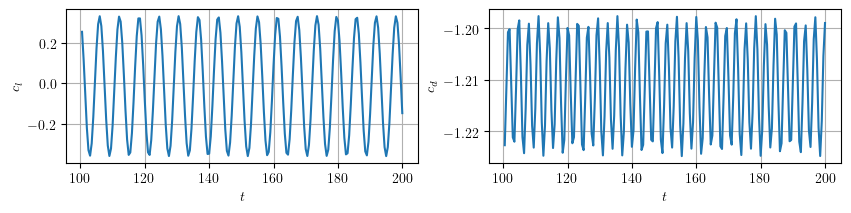

In [10]:
# Postprocessing: Plot sensor data
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

fig, axes = plt.subplots(1, 2, figsize=(10, 2))
t, data = cfg.io.sensor.load_csv_as_dict("boundary")
axes[0].plot(np.array(t, dtype=float), data[('cylinder', 'c_l', '')])
axes[1].plot(np.array(t, dtype=float), data[('cylinder', 'c_d', '')])

axes[0].set_ylabel(r"$c_l$");
axes[1].set_ylabel(r"$c_d$");
for ax in axes:
    ax.grid()
    ax.set_xlabel(r"$t$");

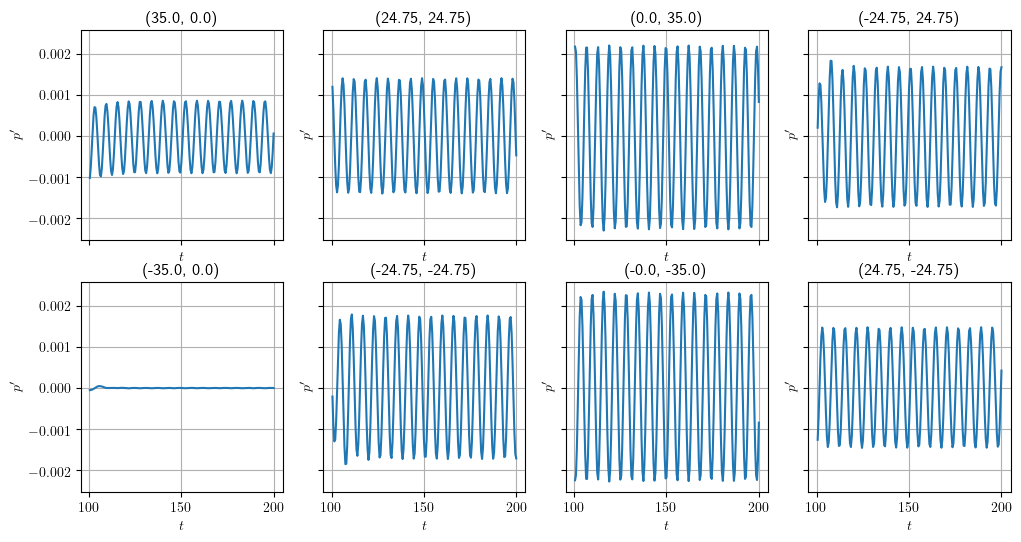

In [11]:
# Postprocessing: Plot sensor data
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
t, data = cfg.io.sensor.load_csv_as_dict("point")
t = np.array(t, dtype=float)

for ax, key in zip(axes.flatten(), data):
    point = tuple(round(val, 2) for val in eval(key[0]))
    ax.plot(t, data[key])
    ax.set_ylabel(r"$p'$")
    ax.set_xlabel(r"$t$")
    ax.set_title(point)
    ax.grid()